In [11]:
%load_ext autoreload
%autoreload 2

import sys

# implementation of reverse_shuffle
sys.path.insert(0, "/Users/user/git/eli5/")
import eli5

sys.path.insert(0, "/Users/user/git/datasci")
from sci.metrics import rmse, rmse_score, neg_rmse_score
import sci.plots as scip
import sci.learn as scil

%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 6)


import scikitplot as skplt

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
pd.set_option('display.float_format', lambda x: '{:.5f}'.format(x)) #Limiting floats output to 3 decimal points
pd.options.display.max_rows = 1000

random_state = 7

modified eli5
modified PermutationImportance sklearn


/Users/user/miniconda3/envs/test2/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


## Load Data

In [12]:
data = scil.load_data("processed_min", random_state=random_state)

print("train:", data.X_train.shape)
print("test:", data.X_test.shape)

(250, 300) (250,)
train: (200, 300)
test: (50, 300)


## Choose Model

In [13]:
from sklearn.model_selection import *

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.linear_model import *
from sklearn import svm
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import *
from sklearn.ensemble import RandomForestClassifier

import xgboost
from xgboost import XGBClassifier, XGBRegressor

import lightgbm as lgb
from lightgbm import LGBMRegressor

from MeanModels import MeanModelsClassifier, MeanModelsRegressor
from StackingAveragedModels import StackingAveragedModels

## Setup

In [14]:
from mlxtend.evaluate import BootstrapOutOfBag, RandomHoldoutSplit
from sklearn.metrics import *

metric = roc_auc_score
scoring = 'roc_auc'

scil.metric_global = metric
scil.scoring_global = 'roc_auc' # make_scorer(scil.metric_global, needs_proba=True)

# format
# cv_{total_splits}_{train/test-fold}
cv_1_10 = RandomHoldoutSplit(valid_size=0.1, stratify=True, random_seed=None)
cv_5_5 = 5
cv_10_10 = 10
cv_1000_10 = RepeatedStratifiedKFold(n_splits=10, n_repeats=100)
cv_1000_20 = RepeatedStratifiedKFold(n_splits=20, n_repeats=50)

cv_single = cv_1_10
cv_fast = cv_10_10
cv_slow = cv_1000_20

## Model hyper-parameter tuning

In [15]:
# fit_params = {
#     'eval_set': [(X_train, y_train), (self.X_test, self.y_test), (X_valid, y_valid)]

# }

ss = {
    'C': (1e-10, 10, 'log-uniform'),
#     'kernel': (['rbf', 'linear', 'poly', 'sigmoid', 'precomputed']),
#     'degree': (1, 5),
#     'gamma': (['auto', 'scale']),
    'gamma': (1e-10, 10, 'log-uniform'),
#     'gamma': (0, 100, 'uniform'),
#     'coef0': (0, 10, 'uniform'),
#     'shrinking': ([True, False]),
#     'tol': (1e-10, 10, 'log-uniform'),

}

# model = SVC(kernel="rbf", C=0.0001316080372376561, probability=True)
# model.set_params(**{'C': 0.10525261119806098, 'intercept_scaling': 0.0004619865290222267, 'tol': 0.009103808108589405})

BaggingClassifier_ss = {
    'n_estimators': (10, 500),
    'max_samples': (0.5, 1, 'uniform'),
#     'max_features': (0.5, 1, 'uniform'),
#     'bootstrap': ([True, False]),
#     'bootstrap_features': ([True, False]),
}
ss = BaggingClassifier_ss

# model_lr_bagging = BaggingClassifier(model_lr, n_estimators=20, max_samples=0.95, bootstrap=False, n_jobs=-2, random_state=random_state)
# {'bootstrap': True, 'max_samples': 0.992921014624782, 'n_estimators': 477}
# {'bootstrap': True, 'max_samples': 0.8038131389021019, 'n_estimators': 12}
# {'bootstrap': True, 'max_samples': 0.9743585669277828, 'n_estimators': 24}
# {'bootstrap': True, 'max_samples': 0.9792611174641446, 'n_estimators': 24}
# model = model_lr_bagging

LogisticRegression_ss = {
    'solver': (['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']),
    'penalty': (['l1', 'l2']),
    'C': (1e-5, 10, 'log-uniform'),
#     'tol': (1e-10, 10, 'log-uniform'),
#     'fit_intercept': ([True, False]),
#     'intercept_scaling': (1e-10, 10, 'log-uniform'),
#     'max_iter': (100, 1e10, 'log-uniform'),
}

model = LogisticRegression(class_weight='balanced', max_iter=1e10)
model = LogisticRegression(class_weight='balanced')
# models_sk['LogisticRegression'].set_params(**{'solver': 'newton-cg', 'C': 0.10525261119806098, 'intercept_scaling': 0.0004619865290222267, 'tol': 0.009103808108589405})
# model_lr = LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')

ss = LogisticRegression_ss
cv = RepeatedStratifiedKFold(5, 2)
# cv = 5


cv = cv_fast
model = my_xgb
ss = {
    'n_estimators': (30, 100),
    'learning_rate': (0.001, 1.0, 'log-uniform'),
    'max_depth': (1, 20),
    'subsample': (0.01, 1.0, 'uniform'),
    'gamma': (1e-09, 10, 'log-uniform'),
    'min_child_weight': (0, 10),
    'reg_lambda': (1e-09, 1000, 'log-uniform'),
    'reg_alpha': (1e-09, 1.0, 'log-uniform'),
    'colsample_bytree': (0.01, 1.0, 'uniform'),
    'colsample_bylevel': (0.01, 1.0, 'uniform'),
}

def search_space_prefix(ss, prefix):
    return {prefix + k: v for k, v in ss.items()}

NameError: name 'my_xgb' is not defined

In [22]:
scil.fit_score(data, mlp)

fitting MLPClassifier ..


MLPClassifier   0.71167
dtype: float64

Can't plot with only a single or no samples


In [32]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(alpha=3)

from sklearn.svm import SVC, LinearSVC, NuSVC

model = NuSVC(probability=True, max_iter=1000)
# {'kernel': 'rbf', 'nu': 0.0006049352962834763}

Running 1000 iterations of BayesSearchCV with 'roc_auc' scoring
with cv = 10
with all_data = True

mean CV 'roc_auc' score: 0.0000
params: {'degree': 1, 'gamma': 'auto', 'kernel': 'rbf', 'nu': 0.7352535094857033}

.
mean CV 'roc_auc' score: 0.7514
params: {'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'nu': 0.39888488080548945}

.........10/1000....
mean CV 'roc_auc' score: 0.7514
params: {'degree': 5, 'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.6690428194379817}

......20/1000..........30/1000.
mean CV 'roc_auc' score: 0.7521
params: {'degree': 4, 'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.006326365097762593}

.........40/1000..........50/1000..........60/1000..........70/1000..........80/1000..........90/1000..........100/1000..........110/1000.........
mean CV 'roc_auc' score: 0.7556
params: {'degree': 5, 'gamma': 'auto', 'kernel': 'rbf', 'nu': 0.003498528168970198}

.120/1000..........130/1000..........140/1000..........150/1000..........160/1000..........170/1000..........180/1000

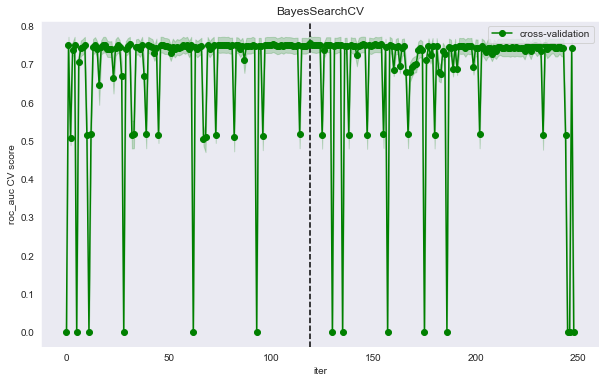

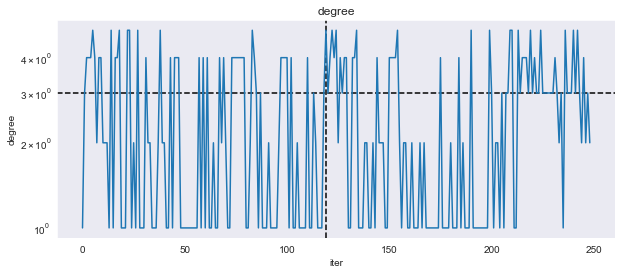

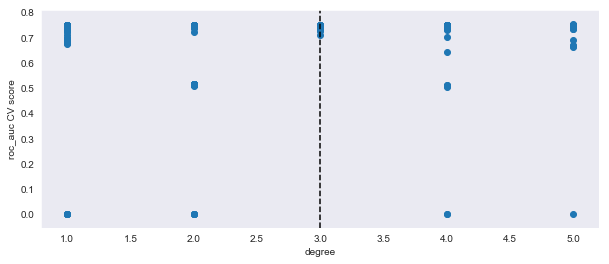

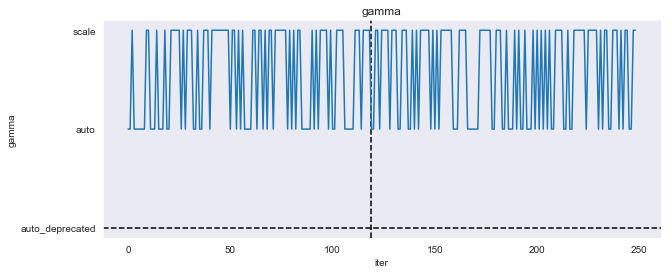

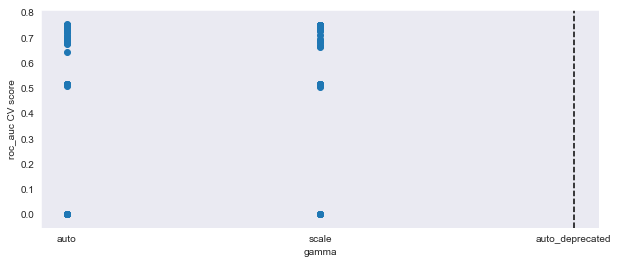

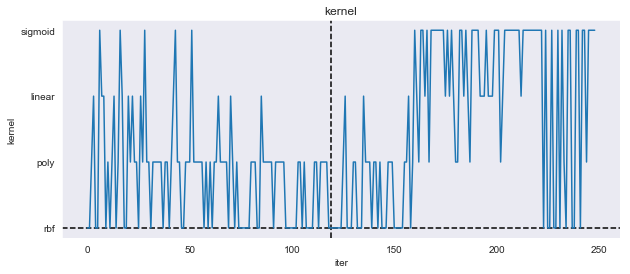

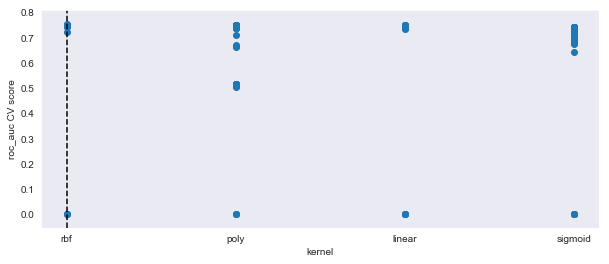

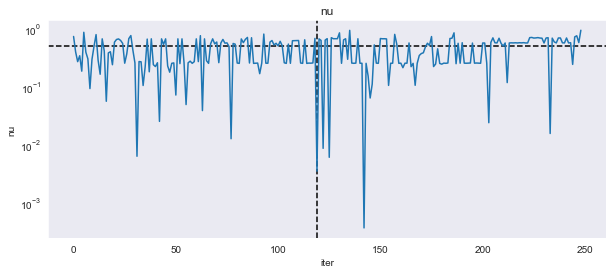

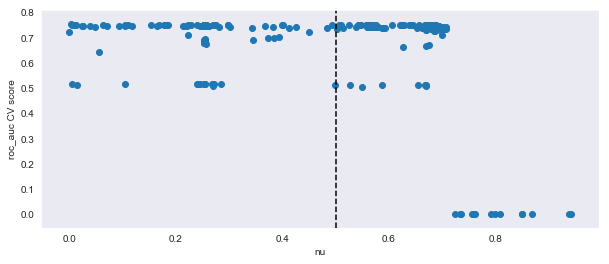

In [34]:
MLPClassifier_ss = {
#     'alpha': (1e-10, 1e5, 'log-uniform')
#     'hidden_layer_sizes': ([(1, ), (2, ), (4, ), (8, ), (16, ), (32, ), (64, ), (128, )]),
    'solver': (['lbfgs', 'sgd', 'adam'])
}

ss = {
    'nu': (1e-10, 1, 'uniform'),
    'kernel': (['linear', 'poly', 'rbf', 'sigmoid']),
    'degree': ([1, 2, 3, 4, 5]),
    'gamma': (['auto', 'scale']),
#     'coef0': (0, 10, 'uniform'),
#     'shrinking': ([True, False])
}

model = model
cv = cv_fast

scil.bayes_search(data, model, n_iter=1000, n_initial_points=20, early_stop=None, search_spaces=ss, scoring=scoring, cv=cv, all_data=True, error_score=0)
# sci.bayes_search(data, model, scoring=sci.scoring_global, cv=RepeatedKFold(5, 1), all_data=True)